<a href="https://colab.research.google.com/github/leekh8/Colaboratory/blob/main/ex10_MLP%2CCNN_%EA%B0%9C%2C%EA%B3%A0%EC%96%91%EC%9D%B4_%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Colaboratory/AISchool/'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Colaboratory/AISchool


# 목표
- 개, 고양이 데이터 이미지를 배열로 변환 (이미지 데이터 전처리)
  - 이미지 자체를 저장소에 업로드하는 것 보다 배열로 변환했을 때 용량 소모 적음
- MLP 이미지 데이터 이진 분류
- CNN 이미지 데이터 이진 분류
- 성능 향상을 위한 노력
  - 이미지 증식
  - 전이학습

In [2]:
# 환경 세팅
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 이미지 다루는 라이브러리
from PIL import Image

In [3]:
# 개고양이 배열 데이터 불러오기
data = np.load('./Data/np_cat_vs_dog.npz')
data

In [4]:
len(data)

4

In [5]:
# 각각의 변수에 데이터 분리해서 담아주기
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# 크기 확인
print("훈련 셋: ", X_train.shape, y_train.shape)
print("테스트 셋: ", X_test.shape, y_test.shape)

훈련 셋:  (2000, 224, 224, 3) (2000,)
테스트 셋:  (1000, 224, 224, 3) (1000,)


# MLP 모델 생성

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# 1. 모델 설계
# 뼈대 구축
mlp_model = Sequential()

# 입력 (3차원 -> 1차)
mlp_model.add(Flatten(input_shape = (224, 224, 3)))

# 중간층
mlp_model.add(Dense(units = 256, activation = 'relu'))
mlp_model.add(Dense(units = 128, activation = 'relu'))
mlp_model.add(Dense(units = 64, activation = 'relu'))

# 출력층 (분류)
mlp_model.add(Dense(units = 1, activation = 'sigmoid'))
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 256)               38535424  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 38576641 (147.16 MB)
Trainable params: 38576641 (147.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# 번역 compile
# pc가 이해하도록 번역
# loss, optimizer, metrics 설정

# 이진 분류
mlp_model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ["accuracy"])

In [9]:
# 조기 학습 중단 설정
# 검증 정확도, 인내심 5번
f_ea = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [10]:
# 학습, 검증 데이터 분리 (7:3), batch_size = 64, 반복 횟수 = 50, 조기 학습 중단 연결
mlp_his = mlp_model.fit(X_train, y_train, validation_split = 0.3, epochs = 50, batch_size = 64, callbacks = [f_ea])

Epoch 1/50
22/22 [==============================] - 8s 39ms/step - loss: 2444.0554 - accuracy: 0.5843 - val_loss: 4842.3057 - val_accuracy: 0.0000e+00
Epoch 2/50
22/22 [==============================] - 0s 19ms/step - loss: 2056.3877 - accuracy: 0.5529 - val_loss: 5609.5776 - val_accuracy: 0.0000e+00
Epoch 3/50
22/22 [==============================] - 0s 22ms/step - loss: 791.4224 - accuracy: 0.6200 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
22/22 [==============================] - 0s 22ms/step - loss: 609.5445 - accuracy: 0.5900 - val_loss: 1462.1985 - val_accuracy: 0.0000e+00
Epoch 5/50
22/22 [==============================] - 0s 18ms/step - loss: 244.0798 - accuracy: 0.6493 - val_loss: 139.6986 - val_accuracy: 0.4567
Epoch 6/50
22/22 [==============================] - 0s 22ms/step - loss: 348.9546 - accuracy: 0.6250 - val_loss: 778.5357 - val_accuracy: 0.0133
Epoch 7/50
22/22 [==============================] - 0s 18ms/step - loss: 227.7224 - accuracy: 0.6264 - val_loss

In [11]:
# test 데이터 활용해 평가하기
# 모델.score(문제, 답) -> 머신 러닝 모델 평가 함수 (sklearn)
# 모델.evaluate(문제, 답) -> 딥러닝 모델 평가 함수 (tensorflow.keras)
mlp_model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 572.3760 - accuracy: 0.5000


[572.3760375976562, 0.5]

# CNN 모델 생성
- 1. 모델 설계 (CNN 층)
- 2. 모델 학습 및 평가 방법 설정
- 3. 모델 학습 및 시각화
- 4. 모델 평가 및 예측

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [13]:
# cnn 신경망 구조 설계
# 뼈대 생성
cnn_model = Sequential()

# 대상에 집중 -> 중요한 특성에 집중 -> 특성 추출
# 특성 추출부(층) - conv(합성곱)
cnn_model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', input_shape = (224, 224, 3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = 2))

cnn_model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = 2))

cnn_model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = 2))

# 고양이, 개 분류부(층) - mlp(입력(1차원으로 펴주는 기능), 중간, 출력층(이진 분류))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation = 'relu'))
cnn_model.add(Dense(1, activation = 'sigmoid'))

# 모델 정보 확인
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)      

In [14]:
# compile
cnn_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])

# fit
cnn_his = cnn_model.fit(X_train, y_train, validation_split= 0.3, batch_size = 64, epochs = 50, callbacks= [f_ea])

Epoch 1/50
22/22 [==============================] - 14s 204ms/step - loss: 385.0046 - accuracy: 0.6114 - val_loss: 1.0898 - val_accuracy: 0.0000e+00
Epoch 2/50
22/22 [==============================] - 2s 102ms/step - loss: 0.6001 - accuracy: 0.7150 - val_loss: 1.1161 - val_accuracy: 0.0000e+00
Epoch 3/50
22/22 [==============================] - 2s 103ms/step - loss: 0.5561 - accuracy: 0.7214 - val_loss: 1.4645 - val_accuracy: 0.0000e+00
Epoch 4/50
22/22 [==============================] - 2s 106ms/step - loss: 0.5213 - accuracy: 0.7421 - val_loss: 1.5257 - val_accuracy: 0.0100
Epoch 5/50
22/22 [==============================] - 2s 103ms/step - loss: 0.4472 - accuracy: 0.7979 - val_loss: 1.6445 - val_accuracy: 0.0867
Epoch 6/50
22/22 [==============================] - 2s 98ms/step - loss: 0.4218 - accuracy: 0.7971 - val_loss: 3.2314 - val_accuracy: 0.2200
Epoch 7/50
22/22 [==============================] - 2s 102ms/step - loss: 0.4493 - accuracy: 0.8271 - val_loss: 2.9773 - val_accuracy:

In [15]:
# 과대적합 보여짐
# 왜 이렇게 학습했을까?
# cnn 틀성에 집중 -> val 예측 성능은 떨어지는 상태
# 데이터는 복잡한 데이터일 수 있읍
# 반대로 모델은 너무 단순할 수 있음

# 평가
cnn_model.evaluate(X_test, y_test)[1]

32/32 [==============================] - 1s 21ms/step - loss: 5.6529 - accuracy: 0.5490


0.5490000247955322

# 데이터 확장하여 cnn 모델 학습 진행하기

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # 이미지 증식

In [17]:
# 증식할 데이터 경로 설정
train_dir = "./Data/cats_and_dogs_filtered/train"
test_dir = "./Data/cats_and_dogs_filtered/test"

# 변형 형식 설정
# 0~255 범위의 수치값을 0~1 사이로 변환
train_gen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, horizontal_flip = True)

# 모델을 일반화 시키는 데이터는 학습용 데이터 (train에 증식 적용)
test_gen = ImageDataGenerator(rescale = 1./255)

In [18]:
# 증식하기 위한 설정 필요
train_generator = train_gen.flow_from_directory(train_dir, target_size = (224, 224), batch_size = 10, class_mode = 'binary')
test_generator = test_gen.flow_from_directory(test_dir, target_size = (224, 224), batch_size = 10, class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
# cnn 신경망 구조 설계
# 뼈대 생성
cnn_model2 = Sequential()

# 대상에 집중 -> 중요한 특성에 집중 -> 특성 추출
# 특성 추출부(층) - conv(합성곱)
cnn_model2.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', input_shape = (224, 224, 3), activation = 'relu'))
cnn_model2.add(MaxPooling2D(pool_size = 2))

cnn_model2.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
cnn_model2.add(MaxPooling2D(pool_size = 2))

cnn_model2.add(Dropout(0.2)) # 20% 특성 제외하고 학습

cnn_model2.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
cnn_model2.add(MaxPooling2D(pool_size = 2))

# 고양이, 개 분류부(층) - mlp(입력(1차원으로 펴주는 기능), 중간, 출력층(이진 분류))
cnn_model2.add(Flatten())
cnn_model2.add(Dense(512, activation = 'relu'))

cnn_model2.add(Dropout(0.2)) # 20% 특성 제외하고 학습 - 특성의 복잡도 줄임

cnn_model2.add(Dense(1, activation = 'sigmoid'))

# 모델 정보 확인
cnn_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)      

In [21]:
# 컴파일
cnn_model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [22]:
# 학습 - 이미지 증식 설정 연결
# 이미지 증식을 하고 학습할 경우, 학습 진행이 들쭉날쭉한 경향
# early stopping 연결 안함
cnn_his2 = cnn_model2.fit_generator(generator = train_generator, validation_data=test_generator, epochs = 20)

<ipython-input-22-723fcd5e2f4c>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_his2 = cnn_model2.fit_generator(generator = train_generator, validation_data=test_generator, epochs = 20)


Epoch 1/20
200/200 [==============================] - 809s 4s/step - loss: 0.8556 - accuracy: 0.5265 - val_loss: 0.6703 - val_accuracy: 0.5150
Epoch 2/20
200/200 [==============================] - 36s 181ms/step - loss: 0.6804 - accuracy: 0.5655 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 3/20
200/200 [==============================] - 34s 171ms/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.6914 - val_accuracy: 0.4950
Epoch 4/20
200/200 [==============================] - 35s 174ms/step - loss: 0.6887 - accuracy: 0.5470 - val_loss: 0.7272 - val_accuracy: 0.5150
Epoch 5/20
200/200 [==============================] - 35s 173ms/step - loss: 0.6903 - accuracy: 0.5380 - val_loss: 0.6865 - val_accuracy: 0.5360
Epoch 6/20
200/200 [==============================] - 35s 173ms/step - loss: 0.6835 - accuracy: 0.5630 - val_loss: 0.6650 - val_accuracy: 0.5860
Epoch 7/20
200/200 [==============================] - 36s 181ms/step - loss: 0.6781 - accuracy: 0.5785 - val_loss: 0.6724 - val_accu

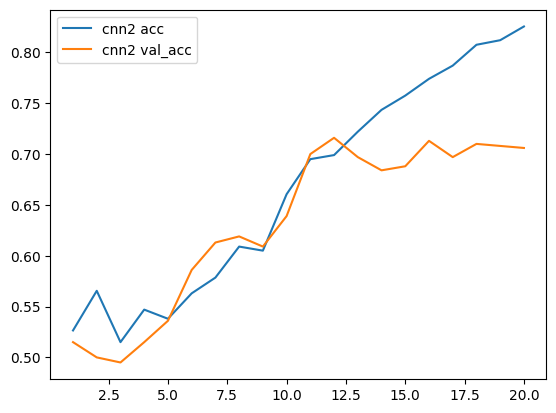

In [30]:
# cnn_model -> cnn_his
# 이미지 증식 학습 cnn_model2 -> cnn_his2
# 선그래프로 시각화하여 비교
# 범례 표시
# 도화지 한장에 4개의 선 그래프 그려보기
cnn1_x = len(cnn_his.history['accuracy'])
plt.plot(range(1, cnn1_x + 1), cnn_his.history['accuracy'], label = 'cnn1 acc')
plt.plot(range(1, cnn1_x + 1), cnn_his.history['val_accuracy'], label = 'cnn1 val_acc')

cnn2_x = len(cnn_his2.history['accuracy'])
plt.plot(range(1, cnn2_x + 1), cnn_his2.history['accuracy'], label = 'cnn2 acc')
plt.plot(range(1, cnn2_x + 1), cnn_his2.history['val_accuracy'], label = 'cnn2 val_acc')

plt.legend()

plt.show()

# 이미지 증식을 통해 과대적합 해소 확인 가능
# 이미지 증식으로 모델 성능 향상
# 이미지 증식 소요 시간 증가

# 전이 학습
- 다른 사람이 만들어놓은 모델을 사용해보자 (시간 단축)
- 완전히 똑같은 데이터로 학습한 것은 아님 (레이블이 다를 수 있음)
- 현재 목표: 고양이 vs 개
- 전이학습 모델: 호랑이 vs 사자 vs 표범
- 분류하려는 대상은 다르지만 판단한다는 기준 비슷할 수 있으니 가져와서 활용해보자

In [42]:
from tensorflow.keras.applications import VGG16
# VGG16: 사전 학습된 모델(pretrained model)

vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))

# include_top: 분류부(전결합)
# weights: 'imagenet' 경진대회 data set을 보며 학습한 모델의 가중치
# imagenet 클래스: 1000개의 사물, 100만장의 사진

vgg16.summary() # 분류부 추가 후 내가 원하는 데이터 추가 학습

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [48]:
# conv 미세 조정
# 동결, 가중치 갱신 막기 -> 학습 불가능하게 설정
# vgg16은 백만장의 사진으로 학습되어 있고, 성능 좋음
# 학습 시 가중치 갱신되면 기존 학습된 내용 훼손 -> 성능 떨어질 수 있음
vgg16.trainable = False

In [49]:
# 분류부 연결
transfer_model = Sequential()
transfer_model.add(vgg16) # 특성 추출부 연결

# 분류부 설계
transfer_model.add(Flatten())
transfer_model.add(Dense(64, activation = 'relu'))
transfer_model.add(Dense(1, activation = 'sigmoid')) # 고양이, 개 분류 (이진 분류)

In [45]:
transfer_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 64)                1605696   
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16320449 (62.26 MB)
Trainable params: 1605761 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [46]:
# compile
transfer_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [38]:
# 마지막 conv 층을 학습 가능하도록 동결시킨 것 풀기
# 해당 층의 이름 확인
for layer in vgg16.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [39]:
# for layer in vgg16.layers:
#   if layer.name == 'block5_conv3':
#     layer.trainable = True
#   else:
#     layer.trainable = False

In [47]:
# fit
transfer_model.fit(X_train, y_train, validation_split = 0.3, epochs = 50, verbose = 2)

Epoch 1/50
44/44 - 11s - loss: 4.1104 - accuracy: 0.6536 - val_loss: 0.7086 - val_accuracy: 0.0000e+00 - 11s/epoch - 240ms/step
Epoch 2/50
44/44 - 8s - loss: 0.3188 - accuracy: 0.7143 - val_loss: 0.8451 - val_accuracy: 0.0000e+00 - 8s/epoch - 180ms/step
Epoch 3/50
44/44 - 8s - loss: 0.2288 - accuracy: 0.8643 - val_loss: 0.8359 - val_accuracy: 0.8983 - 8s/epoch - 188ms/step
Epoch 4/50
44/44 - 8s - loss: 0.2056 - accuracy: 0.9914 - val_loss: 0.8878 - val_accuracy: 0.8700 - 8s/epoch - 191ms/step
Epoch 5/50
44/44 - 8s - loss: 0.1942 - accuracy: 0.9929 - val_loss: 0.8463 - val_accuracy: 0.8850 - 8s/epoch - 192ms/step
Epoch 6/50
44/44 - 8s - loss: 0.1857 - accuracy: 0.9964 - val_loss: 0.8855 - val_accuracy: 0.8633 - 8s/epoch - 187ms/step
Epoch 7/50
44/44 - 8s - loss: 0.1799 - accuracy: 0.9979 - val_loss: 0.9327 - val_accuracy: 0.8533 - 8s/epoch - 185ms/step
Epoch 8/50
44/44 - 8s - loss: 0.1746 - accuracy: 0.9971 - val_loss: 0.8347 - val_accuracy: 0.8783 - 8s/epoch - 179ms/step
Epoch 9/50
44/